In [155]:
import pandas as pd
import datetime as dt
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, Column, Integer, String, Float, MetaData
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [36]:
engine = create_engine("sqlite:///hawaii.sqlite")
#metadata = MetaData()
#metadata.reflect(engine)

Base = automap_base()

Base.prepare(engine, reflect=True)

Station = Base.classes.station
Measurement = Base.classes.measurement

In [118]:
session=Session(bind=engine)
conn=engine.connect()

# Hypothetical vacation will begin at 01/01/2017
start_date = dt.datetime.strptime('01-01-2017','%m-%d-%Y')

# Precipitation Query

In [119]:
last_12_months = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>(start_date-dt.timedelta(days=365)))
last_12_months_df = pd.read_sql(last_12_months.statement,last_12_months.session.bind)

for index, row in last_12_months_df.iterrows():
    last_12_months_df.set_value(index, 'date', row['date'].split(' ')[0])
last_12_months_df.set_index('date',inplace=True)
last_12_months_df.rename(columns={'prcp':'Precipitation'},inplace=True)
last_12_months_df.head()

,Precipitation
date,
2016-01-03,0.00
2016-01-04,0.00
2016-01-05,0.00
2016-01-06,0.00
2016-01-07,0.18


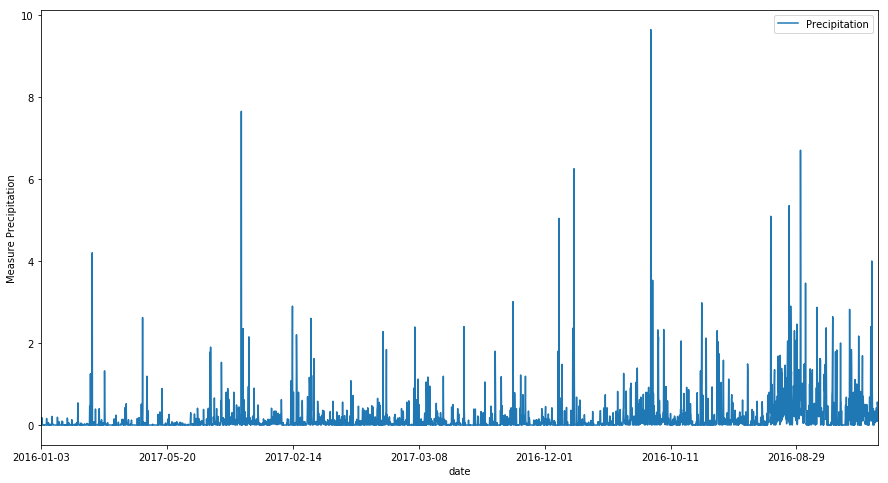

In [120]:
last_12_months_df.plot()

fig = plt.gcf()
fig.set_size_inches(w=15,h=8,forward=True)
plt.ylabel('Measure Precipitation')
plt.show()

In [121]:
last_12_months_df.describe()

,Precipitation
count,3324.000000
mean,0.175072
std,0.487881
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,9.640000


# Station Analysis

In [122]:
num_stations = session.query(Station).count()
num_stations

9

In [123]:
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
station_activity_df = pd.read_sql(station_activity.statement,station_activity.session.bind)
station_activity_df

,station,count_1
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [124]:
highest_activity_station = station_activity_df['station'][0]
highest_activity_station

'USC00519281'

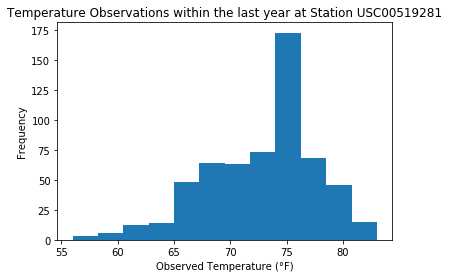

In [125]:
recent_temp_obs = session.query(Measurement.tobs).filter(Measurement.date>(start_date-dt.timedelta(days=365)),Measurement.station==highest_activity_station)
recent_temp_obs_df = pd.read_sql(recent_temp_obs.statement,recent_temp_obs.session.bind)
plt.hist(recent_temp_obs_df['tobs'],bins=12)
plt.ylabel('Frequency')
plt.xlabel('Observed Temperature (°F)')
plt.title('Temperature Observations within the last year at Station %s'%highest_activity_station)

plt.show()

In [132]:

def calc_temps(start,end):
    start_datetime = dt.datetime.strptime(start,'%Y-%m-%d')
    end_datetime = dt.datetime.strptime(end,'%Y-%m-%d')
    temp_q = session.query(Measurement.tobs).filter(Measurement.date>start_datetime,Measurement.date<end_datetime)
    temp_df = pd.read_sql(temp_q.statement,temp_q.session.bind)
    max_temp = temp_df['tobs'].max()
    min_temp = temp_df['tobs'].min()
    avg_temp = temp_df['tobs'].mean()
    return (max_temp,min_temp,avg_temp)

In [134]:
start = '2016-01-01'
end = '2016-01-04'
(max_temp,min_temp,avg_temp) = calc_temps(start,end)

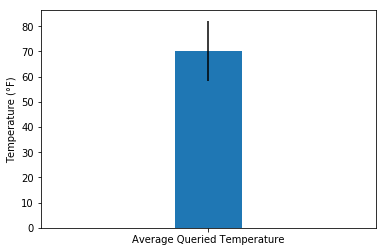

In [151]:
plt.bar(x=2,height=avg_temp,yerr=max_temp-min_temp,tick_label='Average Queried Temperature')
plt.xlim(0,4)
plt.ylabel('Temperature (°F)')
plt.show()

# See app.py for flask application